# EdU+ nuclei Analysis

From the previous segmentation, the median fluorescence intensity value (and other estimators) for each nuclei was included. We want to be able to distinguish between positively stained nuclei from negative ones and then relate them to their size. With this information, we would like to see:

1. Are EdU+ nuclei always bigger?



## Load dependencies and datasets

We will begin by loading the necessary dependencies, stating the path to the dataset and loading it.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pandas as pd
import seaborn as sns
from scipy.stats import mannwhitneyu, chi2_contingency


from nuclei_segmenter.loader import get_nuclei_size_df
from nuclei_segmenter.quantify import find_edu_nuclei_in_df
from nuclei_segmenter.vis import get_contours, labeled_colormap, my_positive_colormap, my_negative_colormap

In [2]:
DATA_DIR = pathlib.Path(r'C:\Users\agucor\Karolinska Institutet\Afshan Iqbal - EdU staining IGF1 Exp')
BIG_DATA_DIR = pathlib.Path(r'C:\Users\agucor\Karolinska Institutet\Afshan Iqbal - EdU staining IGF1 Exp\sparse nuclei')

In [3]:
nuclei_size_original = get_nuclei_size_df(DATA_DIR)
nuclei_size_big = get_nuclei_size_df(BIG_DATA_DIR)
nuclei_size = pd.concat([nuclei_size_original, nuclei_size_big], ignore_index=True)

nuclei_size = nuclei_size.astype({'label': int, 
                                      'condition': 'category', 
                                      'cell_line': 'category', 
                                      'region': 'category', 
                                      'sample_number': 'category', 
                                    })
nuclei_size = nuclei_size.astype({'igf1': 'category'})

nuclei_size

,area_2D,eccentricity,equivalent_diameter_area,intensity_mean_2D,label,z,area_3D,intensity_mean_3D,intensity_mean_edu,intensity_median,area,volume,sample_name,condition,cell_line,region,sample_number,igf1
0,134,0.694508,13.061933,50071.798507,59,4,346,31987.965318,303.234104,301.0,54.444321,1405.801117,Ndr1219 hilar ctrl -1,Ndr,1219,Hilar,1,Control
1,100,0.563438,11.283792,48793.960000,63,4,185,32735.221622,292.643243,280.0,40.630090,751.656666,Ndr1219 hilar ctrl -1,Ndr,1219,Hilar,1,Control
2,169,0.805656,14.668929,11530.520710,64,3,169,11530.520710,326.071006,312.0,68.664852,686.648522,Ndr1219 hilar ctrl -1,Ndr,1219,Hilar,1,Control
3,229,0.491526,17.075475,50432.737991,65,4,599,32087.337229,21779.205342,23463.0,93.042906,2433.742396,Ndr1219 hilar ctrl -1,Ndr,1219,Hilar,1,Control
4,171,0.588731,14.755472,54342.304094,66,4,513,35846.684211,490.385965,299.0,69.477454,2084.323621,Ndr1219 hilar ctrl -1,Ndr,1219,Hilar,1,Control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187573,207,0.767882,16.234549,10168.420290,436,0,207,10168.420290,105.169082,82.0,26.868855,214.950842,Wt1225 hilar ctrl-9,WT,1225,Hilar,9,Control
187574,85,0.542482,10.403142,14924.211765,437,0,85,14924.211765,286.847059,164.0,11.033105,88.264838,Wt1225 hilar ctrl-9,WT,1225,Hilar,9,Control
187575,274,0.657265,18.677999,15847.233577,440,0,274,15847.233577,92.861314,77.5,35.565538,284.524303,Wt1225 hilar ctrl-9,WT,1225,Hilar,9,Control
187576,367,0.835926,21.616635,2475.482289,445,0,367,2475.482289,113.245232,83.0,47.637052,381.096420,Wt1225 hilar ctrl-9,WT,1225,Hilar,9,Control


## Find EdU nuclei

Find EdU nuclei takes a DataFrame and groups by images to find a threshold which will be used to classify between EdU positive and negative nuclei.

In [4]:
nuclei_size = find_edu_nuclei_in_df(nuclei_size, intensity_col='intensity_mean_edu')

## Load and show EdU detection examples

To assess if the EdU classification is working correctly, we should plot the contours of each nuclei according to EdU positivity. It would be nice to add a plot of the image with all the nuclei and maybe their size.

In [5]:
from nuclei_segmenter.loader import get_file, get_image, get_edu_image, get_labeled

def get_images(filepath):
    file = get_file(filepath)
    img = get_image(file)
    edu = get_edu_image(file)

    prop_df = pd.read_excel(DATA_DIR / 'nuclei_size.xlsx', sheet_name=filepath.stem)
    good_planes = prop_df.z.unique()
    if len(good_planes) == 0:
        return None, None
    return img[good_planes], edu[good_planes]

In [6]:
IMG_DIR = DATA_DIR / 'data'
SEG_DIR = DATA_DIR / 'segmented'

files = [filepath.relative_to(SEG_DIR) for filepath in SEG_DIR.rglob('*.tiff')]

In [7]:
this_filepath = files[1]
this_df = nuclei_size.query(f'sample_name == "{this_filepath.stem}"')

In [8]:
from nuclei_segmenter.vis import relabel

img, edu = get_images(IMG_DIR / files[1].with_suffix('.czi'))
labeled = get_labeled(SEG_DIR / files[1])

all_labels = np.arange(np.max(labeled))
present_labels = [label if label in this_df.label.values else 0 for label in all_labels]
edu_pos_labeled = relabel(labeled, zip(this_df.edu.values + 1, this_df.label.values))
labeled = relabel(labeled, zip(present_labels, all_labels))

In [9]:
def plot_edu_classification(img, edu, edu_pos_labeled):
    fig, axs = plt.subplots(2, 2, figsize=(17, 17))

    axs[0, 0].imshow(np.max(img, axis=0))

    axs[0, 1].imshow(np.max(edu, axis=0))

    axs[0, 0].axis('off')
    axs[0, 1].axis('off')

    axs[1, 0].imshow(np.max(img, axis=0))

    contours = get_contours(np.max(labeled, axis=0))
    axs[1, 0].imshow(contours, cmap=labeled_colormap, vmin=0.1, interpolation='none')

    axs[1, 1].imshow(np.max(edu, axis=0))

    contours_positive = get_contours(np.max(edu_pos_labeled == 2, axis=0).astype(int))
    axs[1, 1].imshow(contours_positive, cmap=my_positive_colormap, vmin=0.1, interpolation='none')

    contours_negative = get_contours(np.max(edu_pos_labeled == 1, axis=0).astype(int))
    axs[1, 1].imshow(contours_negative, cmap=my_negative_colormap, vmin=0.1, interpolation='none')

    axs[1, 0].axis('off')
    axs[1, 1].axis('off')

    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    return axs

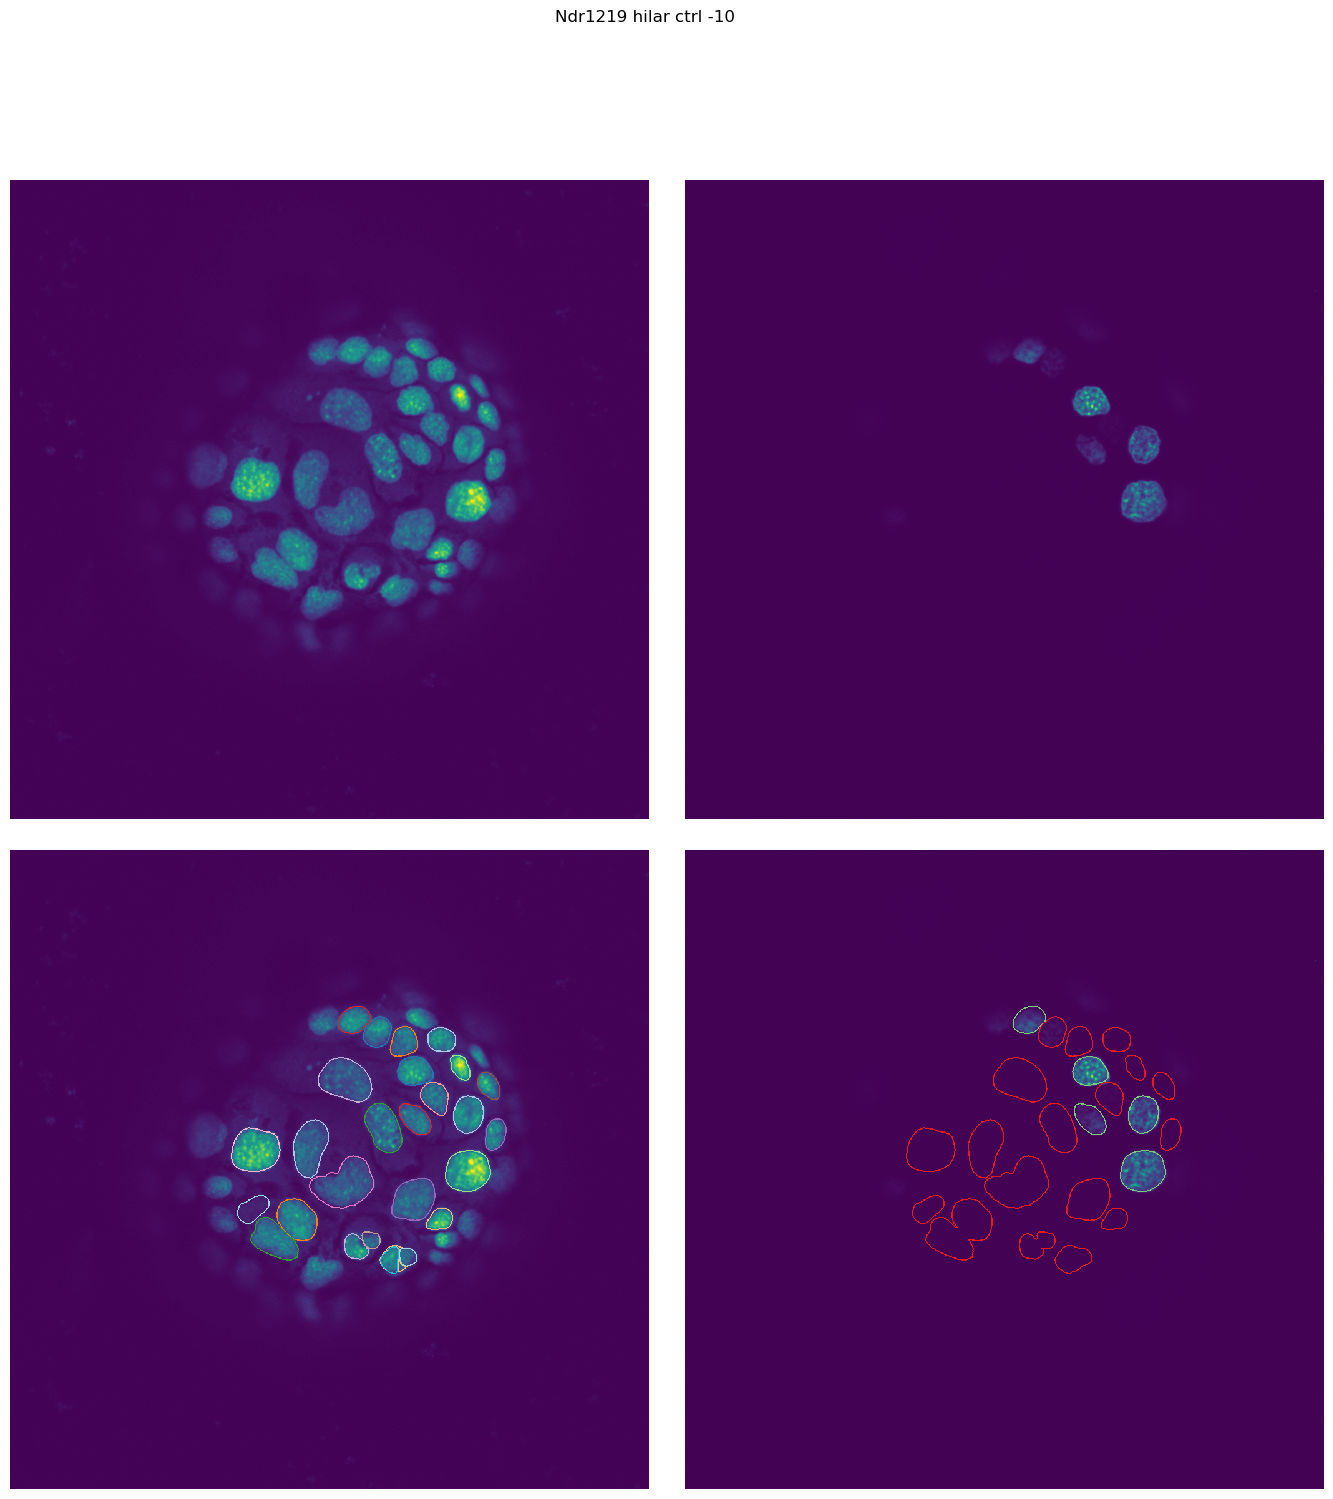

In [10]:
plot_edu_classification(img, edu, edu_pos_labeled)
plt.suptitle(this_filepath.stem)
plt.show()

# EdU+ nuclei

After assessing that the algorithm distinguishes between positive and negative nuclei, we can look into:

1. If we have more EdU+ nuclei in some particular conditions;

2. How different EdU+ nuclei are in size.

## How many EdU+ nuclei are there in each condition?

Are there more EdU+ nuclei in some region or condition?

Let's first subset the control organoids and compare across genotypes in the different regions.

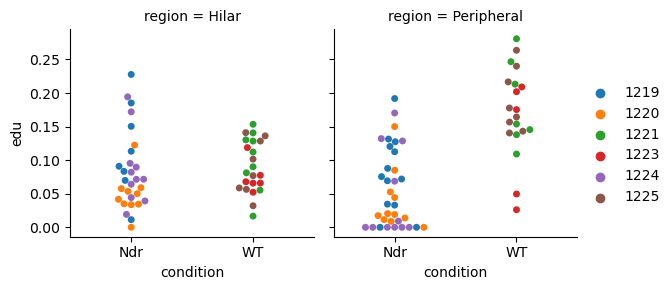

In [11]:
ratio_df = nuclei_size.query('igf1 == "Control"').groupby('sample_name').agg({
    'edu': lambda s: sum(s)/len(s), 
    'cell_line': 'first', 
    'region': 'first', 
    'condition': 'first', 
    'igf1': 'first'})

g = sns.FacetGrid(data=ratio_df, col='region')
g.map_dataframe(sns.swarmplot, y="edu", x='condition', hue='cell_line', palette='tab10')
g.add_legend()
plt.show()

In [12]:
for conds, this_df in ratio_df.query('igf1 == "Control"').groupby('region'):
    test_result = mannwhitneyu(this_df.query('condition == "WT"').edu.values, this_df.query('condition == "Ndr"').edu.values)
    print(f"p-value for Mann-Whitney U test in {conds} region of Control organoids is {test_result.pvalue:.4f}")

p-value for Mann-Whitney U test in Hilar region of Control organoids is 0.2383
p-value for Mann-Whitney U test in Peripheral region of Control organoids is 0.0000


In the periphery there is a statistical higher proliferation rate in WT organoids with respect to Ndr ones. In the Hilar region, this difference is not statistically significant.

### Is there some correlation between size of the organoid (proxy: number of nuclei) and EdU+ nuclei percentage?

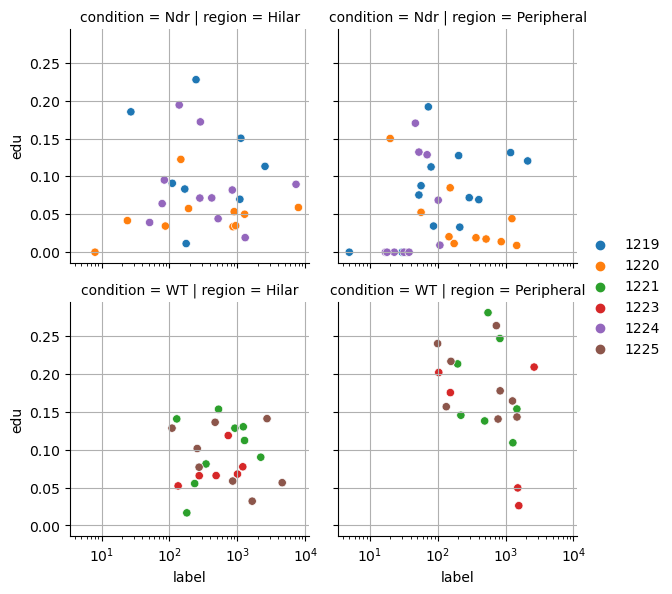

In [13]:
ratio_df = nuclei_size.query('igf1 == "Control"').groupby('sample_name').agg({
    'edu': lambda s: sum(s)/len(s),
    'label': 'count',
    'cell_line': 'first', 
    'region': 'first', 
    'condition': 'first', 
    'igf1': 'first'})

g = sns.FacetGrid(data=ratio_df, col='region', row='condition')
g.map_dataframe(sns.scatterplot, y="edu", x='label', hue='cell_line', palette='tab10')
g.add_legend()
plt.semilogx()
for ax in g.axes.flatten():
    ax.grid()
plt.show()

These distributions might be worth considering. Previous results show that percentage of EdU+ nuclei for WT should be higher and between 15% and 40%.

### Does IGF1 treatment increse the number of EdU+ nuclei?

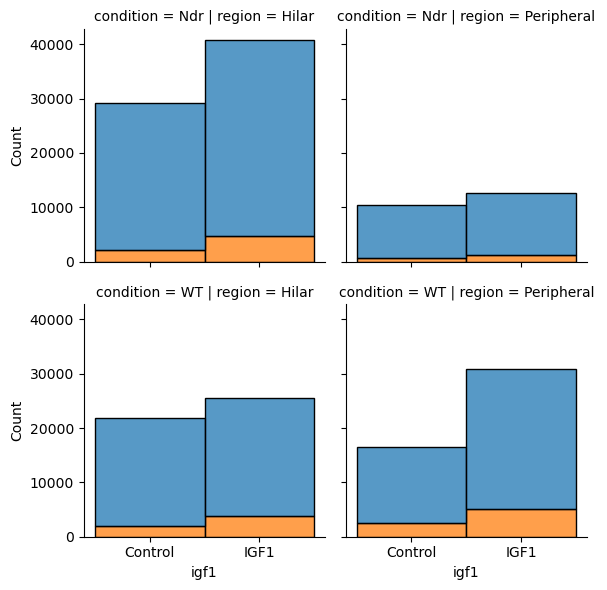

In [14]:
g = sns.FacetGrid(data=nuclei_size, col='region', row='condition')
g.map_dataframe(sns.histplot, x="igf1", hue='edu', stat='count', multiple='stack')
g.add_legend()
plt.show()

IGF1 treatment seems to increase the number of cells as well as the number of EdU+ cells.

*Note*: There are less Ndr Peripheral nuclei than in other conditions.

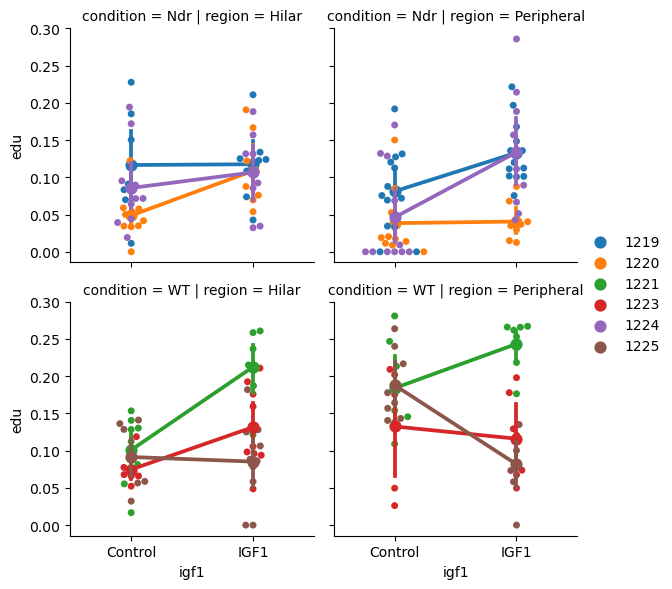

In [15]:
ratio_df = nuclei_size.groupby('sample_name').agg({'edu': lambda s: sum(s)/len(s), 'cell_line': 'first', 'region': 'first', 'condition': 'first', 'igf1': 'first'})
g = sns.FacetGrid(data=ratio_df, col='region', row='condition')
g.map_dataframe(sns.swarmplot, y="edu", x='igf1', hue='cell_line', palette='tab10')
g.map_dataframe(sns.pointplot, y="edu", x='igf1', hue='cell_line', palette='tab10')
g.add_legend()
plt.show()

In [16]:
for conds, this_df in ratio_df.groupby(['region', 'condition']):
    test_result = mannwhitneyu(this_df.query('igf1 == "Control"').edu.values, this_df.query('igf1 == "IGF1"').edu.values)
    print(f"p-value for Mann-Whitney U test in {conds} of Control organoids vs IGF1 treated is {test_result.pvalue:.4f}")

p-value for Mann-Whitney U test in ('Hilar', 'Ndr') of Control organoids vs IGF1 treated is 0.0179
p-value for Mann-Whitney U test in ('Hilar', 'WT') of Control organoids vs IGF1 treated is 0.0216
p-value for Mann-Whitney U test in ('Peripheral', 'Ndr') of Control organoids vs IGF1 treated is 0.0011
p-value for Mann-Whitney U test in ('Peripheral', 'WT') of Control organoids vs IGF1 treated is 0.4895


There is a statistical difference in the percentage of EdU+ nuclei between IGF1 treated and Control organoids in Ndr Periphery. There are no statistical differences in other regions or genotypes.

### Is there a repeated pattern if we analyze per cell line?

Maybe for every cell line, EdU+ nuclei percentage is always higher in IGF1 treated organoids. This could be maske when avergaing populations, something similar to Simpson's paradox.

In [37]:
from pingouin import friedman

for conds, this_df in ratio_df.groupby(['region', 'condition']):
    df_long = this_df[['cell_line', 'igf1', 'edu']]
    test_result = friedman(data=df_long, dv='edu', within='igf1', subject='cell_line')
    print(f"p-value for Friedman test in {conds} of Control organoids vs IGF1 treated is {test_result['p-unc'].values[0]:.4f} separated by cell line")

[0.08326452]
p-value for Friedman test in ('Hilar', 'Ndr') of Control organoids vs IGF1 treated is 0.0833 separated by cell line
[0.56370286]
p-value for Friedman test in ('Hilar', 'WT') of Control organoids vs IGF1 treated is 0.5637 separated by cell line
[0.08326452]
p-value for Friedman test in ('Peripheral', 'Ndr') of Control organoids vs IGF1 treated is 0.0833 separated by cell line
[0.56370286]
p-value for Friedman test in ('Peripheral', 'WT') of Control organoids vs IGF1 treated is 0.5637 separated by cell line


Analyzing per cell line does not show a shared behaviour between cell lines.

## EdU+ nuclei sizes

Let's take a look at nuclei sizes in different conditions.

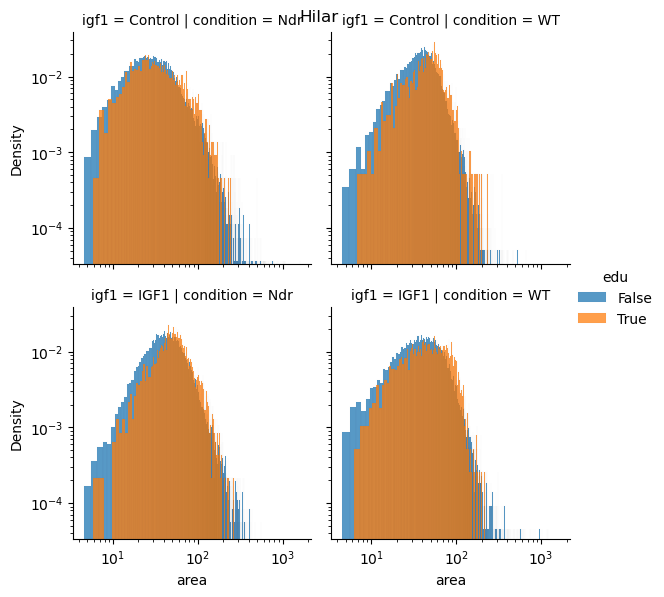

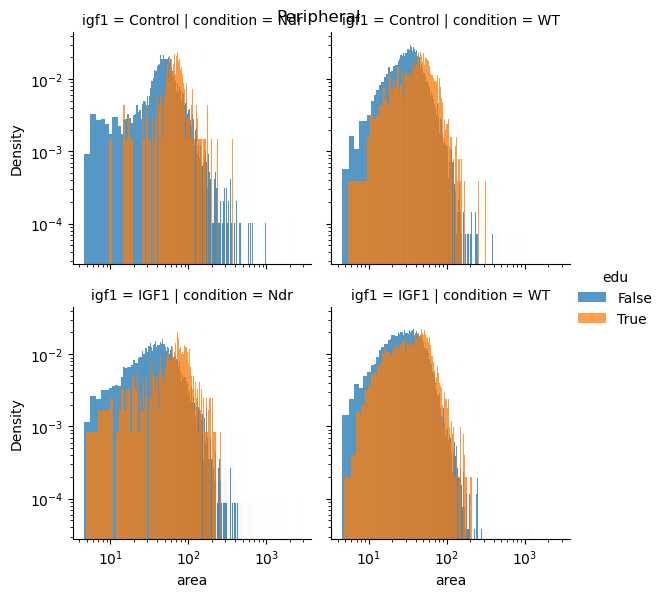

In [17]:
for region, this_df in nuclei_size.groupby('region'):
    g = sns.FacetGrid(data=this_df, col='condition', row='igf1', hue='edu')
    g.map_dataframe(sns.histplot, x="area", stat='density', discrete=True, common_norm=False)
    g.add_legend()
    plt.semilogx()
    plt.semilogy()
    plt.suptitle(region)
    plt.subplots_adjust()
    plt.show()

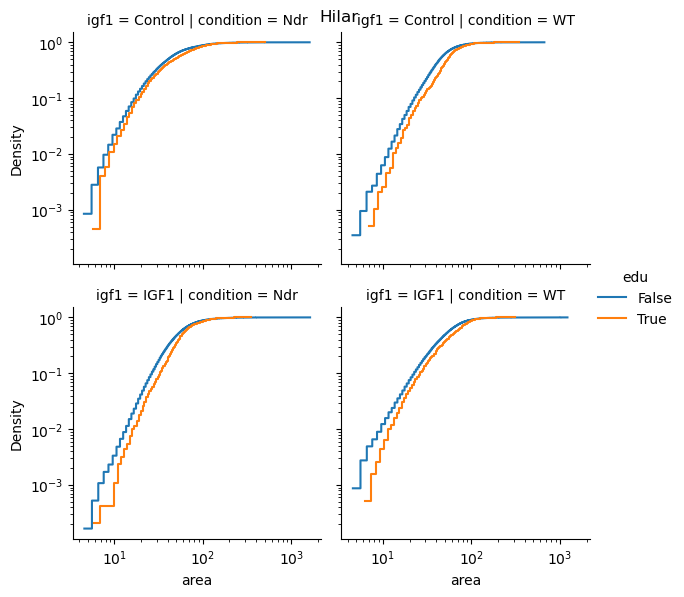

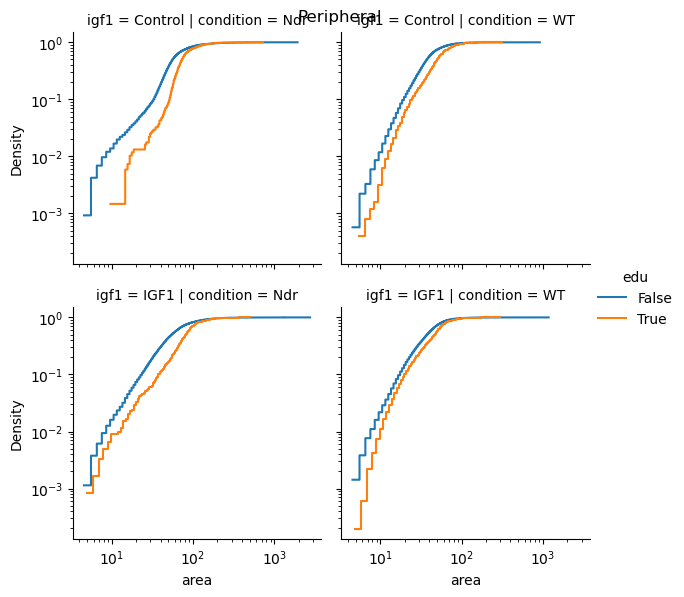

In [18]:
for region, this_df in nuclei_size.groupby('region'):
    g = sns.FacetGrid(data=this_df, col='condition', row='igf1', hue='edu')
    g.map_dataframe(sns.histplot, x="area", discrete=True, cumulative=True, fill=False, element='step', stat='density', common_norm=False)
    g.add_legend()
    plt.semilogx()
    plt.semilogy()
    plt.suptitle(region)
    plt.subplots_adjust()
    plt.show()

EdU+ nuclei tend to be bigger than EdU- ones.

The remaining questions is whether we find big nuclei in the EdU+ population.

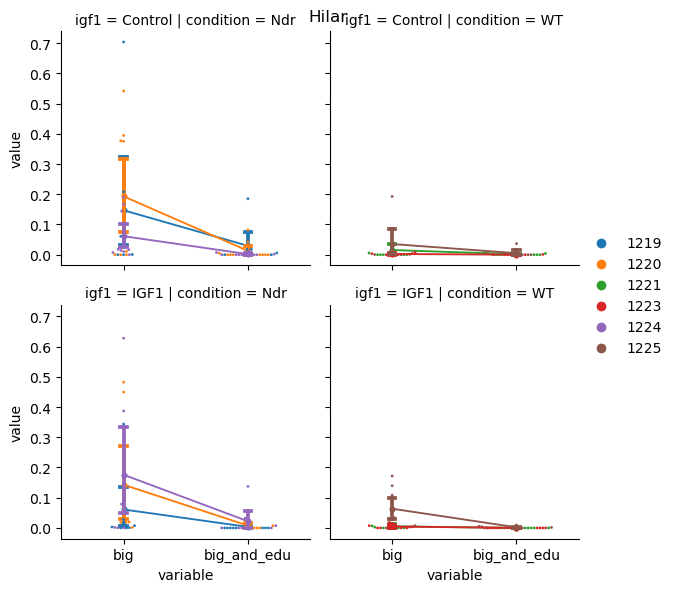

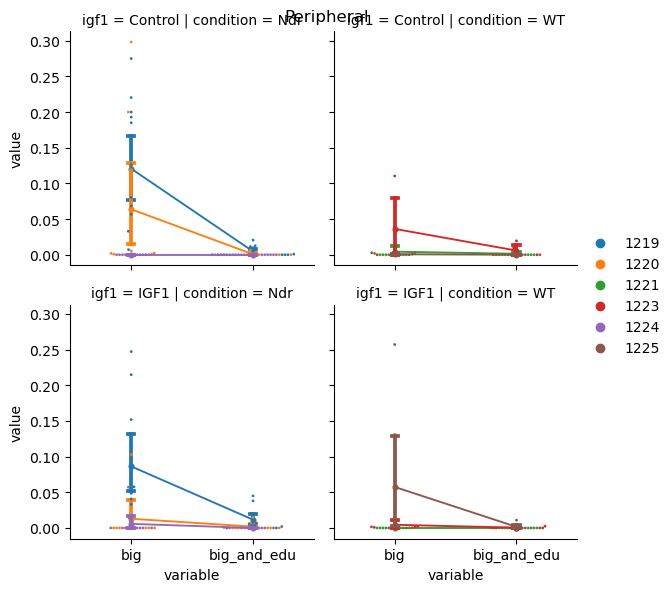

In [19]:
nuclei_size['big'] = nuclei_size.area.values > 201
nuclei_size['big_and_edu'] = np.logical_and(nuclei_size['big'].values, nuclei_size['edu'].values)
big_df = nuclei_size.groupby('sample_name').agg({'big': lambda x: sum(x)/len(x), 
                                                 'edu': lambda x: sum(x)/len(x), 
                                                 'big_and_edu': lambda x: sum(x)/len(x), 
                                                 'condition': 'first', 
                                                 'region': 'first', 
                                                 'cell_line': 'first', 
                                                 'igf1':'first'})

for region, this_df in big_df.groupby('region'):
    g = sns.FacetGrid(data=this_df.reset_index(drop=False).melt(
        id_vars=['sample_name', 'condition', 'igf1', 'cell_line'], value_vars=['big', 'big_and_edu']),
          col='condition', row='igf1')
    g.map_dataframe(sns.pointplot, x="variable", y='value', hue='cell_line', capsize=.05, scale=0.5, palette='tab10')
    g.map_dataframe(sns.swarmplot, x="variable", y='value', size=2, hue='cell_line', palette='tab10')
    g.add_legend()
    plt.suptitle(region)
    plt.ylabel('Percentage of nuclei per organoid')
    plt.subplots_adjust()
    plt.show()

In [20]:
for conds, this_df in big_df.groupby(['region', 'condition', 'igf1']):
    test_result = mannwhitneyu(this_df.big.values, 
                               this_df.big_and_edu.values, 
                               alternative='greater')
    print(f"p-value for Mann-Whitney U one-sided test in {conds} \nof percentage of big nuclei is greater than big and being EdU+ \nis {test_result.pvalue:.4f}")

p-value for Mann-Whitney U one-sided test in ('Hilar', 'Ndr', 'Control') 
of percentage of big nuclei is greater than big and being EdU+ 
is 0.0000
p-value for Mann-Whitney U one-sided test in ('Hilar', 'Ndr', 'IGF1') 
of percentage of big nuclei is greater than big and being EdU+ 
is 0.0000
p-value for Mann-Whitney U one-sided test in ('Hilar', 'WT', 'Control') 
of percentage of big nuclei is greater than big and being EdU+ 
is 0.0236
p-value for Mann-Whitney U one-sided test in ('Hilar', 'WT', 'IGF1') 
of percentage of big nuclei is greater than big and being EdU+ 
is 0.0003
p-value for Mann-Whitney U one-sided test in ('Peripheral', 'Ndr', 'Control') 
of percentage of big nuclei is greater than big and being EdU+ 
is 0.0000
p-value for Mann-Whitney U one-sided test in ('Peripheral', 'Ndr', 'IGF1') 
of percentage of big nuclei is greater than big and being EdU+ 
is 0.0270
p-value for Mann-Whitney U one-sided test in ('Peripheral', 'WT', 'Control') 
of percentage of big nuclei is grea

In general, big and EdU+ population is different from the only big nuclei population. Although this is expected, as we are adding an extra condition, it is not always the case. In WT peripheral control organoids, we can not reject the hypothesis that these distributions are different. We can reject these hypothesis with 95% confidence in Ndr Peripheral IGF1 treated and WT Hilar control organoids and more than 99% confidence in the remaining cases.

My next question is, if we make a contingency table of being big or not versus being EdU positive and not, is it possible that the ratio of EdU+ is the same in big and not big nuclei?

In [21]:
def get_contingency_table(this_df):
    return pd.crosstab(this_df['big'].values, this_df['edu'].values).values

def my_chi2_contingency_test(this_df):
    print('For the null hypothesis, we will assume that the probability of being \nEdU+ is the same disregarding if it is a big nuclei or not.')
    this_table = get_contingency_table(this_df)
    test_result = chi2_contingency(this_table)
    print('This is the contingency table:')
    print(this_table)
    print('\nThis is the ratio of EdU+ for normal nuclei and big nuclei.')
    print(this_table[1] / this_table[0])
    print(f"p-value for chi-squared independence test is {test_result[1]:.4f}")

print('All Nuclei\n===========\n')
my_chi2_contingency_test(nuclei_size)

for conds, this_df in nuclei_size.groupby(['region', 'condition', 'igf1']):
    print(f'\n\n{conds}\n===========\n')
    my_chi2_contingency_test(this_df)
    

All Nuclei

For the null hypothesis, we will assume that the probability of being 
EdU+ is the same disregarding if it is a big nuclei or not.
This is the contingency table:
[[163109  21949]
 [  2378    142]]

This is the ratio of EdU+ for normal nuclei and big nuclei.
[0.01457921 0.00646954]
p-value for chi-squared independence test is 0.0000


('Hilar', 'Ndr', 'Control')

For the null hypothesis, we will assume that the probability of being 
EdU+ is the same disregarding if it is a big nuclei or not.
This is the contingency table:
[[26383  2177]
 [  558    30]]

This is the ratio of EdU+ for normal nuclei and big nuclei.
[0.02114998 0.01378043]
p-value for chi-squared independence test is 0.0272


('Hilar', 'Ndr', 'IGF1')

For the null hypothesis, we will assume that the probability of being 
EdU+ is the same disregarding if it is a big nuclei or not.
This is the contingency table:
[[35358  4650]
 [  690    31]]

This is the ratio of EdU+ for normal nuclei and big nuclei.
[0.01951468

If we pool all nuclei together, the null hypothesis can be rejected so we can assume that big nuclei do not have the same ratio of EdU+ nuclei.

If we group by region, genotype and treatment, Hilar Ndr IGF1 treated, Hilar WT IGF1 treated and Peripheral WT IGF1 treated organoids show that the null hypothesis can be rejected in these cases.

In the remaining cases, we can not reject the hypothesis that big and not big nuclei have the same ratio of EdU+ nuclei.